In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm
import time
import os

In [106]:
class config:
    BASE_PATH = "../msc-ai-2022/"
    TRAIN_IMG_PATH = BASE_PATH + "train_images/train_images"
    TRAIN_MASK_PATH = BASE_PATH + "train_masks/train_masks"
    TEST_IMG_PATH = BASE_PATH + "test_images/test_images"

# 1. Dataloaders

In [107]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 5

In [109]:
# Create a custom Dataset class
class tensorDataset(Dataset):
    def __init__(self, image_paths: list, mask_paths: list, train: bool):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        
        self.transform_img = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH]),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize([HEIGHT,WIDTH], interpolation = transforms.InterpolationMode.NEAREST), # Important
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        
        # Select a specific image's path
        img_path  = self.image_paths[index]
        mask_path = self.mask_paths[index]
        
        # Load the image
        img = Image.open(img_path)
        mask = Image.open(mask_path)
    
        # Apply transformations
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        
        # Scale the mask from 0-1 range to 0-255 range
        mask = mask * 255  
        
        # Reshape mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W) not (B, 1, H, W)
        mask = mask.squeeze(0)
        
        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [110]:
# Very simple train/test split
train_ratio = 0.7
train_set_last_idx = int(len(glob.glob(config.TRAIN_IMG_PATH + "/*")) * train_ratio)

train_img_paths  = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[:train_set_last_idx]
train_mask_paths = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[:train_set_last_idx]
val_img_paths    = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))[train_set_last_idx:]
val_mask_paths   = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))[train_set_last_idx:]

# Create datasets
train_dataset = tensorDataset(train_img_paths, train_mask_paths, train=True)
val_dataset   = tensorDataset(val_img_paths, val_mask_paths, train=False)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [111]:
# Test dataloaders
start = time.time()
for batch in tqdm(train_dataloader):
    img_batch, img_mask = batch

for batch in tqdm(val_dataloader):
    img_batch, img_mask = batch
      
end = time.time()
print(f'Seconds needed to load one train + val epoch: {end - start :.3f}')

100%|██████████| 16/16 [00:24<00:00,  1.56s/it]

Seconds needed to load one train + val epoch: 80.406


The dataloaders are extremely slow! It takes around a minute to load one epoch, which can be a huge overhead if you want to train for e.g. 100 epochs. The reason is that the images are quite large (some around 3000x4000) and loading such images takes a lot of time. Ideally, for this dataset you should have dataloaders that load one epoch in a few seconds at max. To achieve this we can do a few things:

1. We could pre-process the images. Reszing the images beforehand to the desired height and width, will significantly decrease the loading time.
2. We could increase the number of workers. However, remember that the more batches you store at once, the less memory you have for other operations.

## 2. Model definition

In [7]:
# class BasicBlock(nn.Module):
#     def __init__(self, in_channels: int, forward_expansion: int,  out_channels: int, expand: bool):
#         super(BasicBlock, self).__init__()
#         """
#         A very simple convlution block. Reduces or expands the size of the image by a factor of 2.
#         When using batchnorm, you can set bias=False to preceding convolution.
#         """
#         self.conv1 = nn.Conv2d(in_channels, forward_expansion, 3, stride=1, padding='same', bias=False)
#         self.bn1 = nn.BatchNorm2d(forward_expansion)
#         self.conv2 = nn.Conv2d(forward_expansion, out_channels, 3, stride=1, padding='same', bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         if expand:
#             self.scaling = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
#         else:
#             self.scaling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#     def forward(self, x):
#         x = self.bn1(self.conv1(x))
#         x = F.relu(x)
#         x = self.bn2(self.conv2(x))
#         x = F.relu(x)
#         x = self.scaling(x)
#         return x

    
# class SampleModel(nn.Module):
#     def __init__(self, in_channels=3, out_channels=25):
#         super(SampleModel, self).__init__()
        
#         # Create downsizing pass
#         self.down = nn.ModuleList()
#         self.down.append(BasicBlock(3, 256, 256, expand=False))
#         self.down.append(BasicBlock(256, 512, 512, expand=False))
#         self.down.append(BasicBlock(512, 512, 1024, expand=False))
        
#         # Create bottleneck
#         self.bottleneck = nn.Conv2d(1024, 1024, 3, stride=1, padding='same')
        
#         # Create upsizing pass
#         self.up = nn.ModuleList()
#         self.up.append(BasicBlock(1024, 512, 512, expand=True))
#         self.up.append(BasicBlock(512, 512, 256, expand=True))
#         self.up.append(BasicBlock(256, 256, out_channels, expand=True))
        
#     def forward(self, x):
#         for block in self.down:
#             x = block(x)
#         x = self.bottleneck(x)
#         for block in self.up:
#             x = block(x)
#         return x

In [112]:
# Unet (use an unet to do segmentation)
from collections import OrderedDict

import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# 3. Training loop

In [113]:
def train(model, epochs, optimizer, criterion):
    
    for epoch in range(epochs):
        
        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []
      
        ###### Train model ######
        model.train()
        for i, batch in enumerate(train_dataloader):
            # Extract images and masks
            img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
            img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)
            
            # Optimize network
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 25, H, W]
            loss = criterion(output, mask_batch)
            loss.backward()
            optimizer.step()
          
            # Save batch results
            train_losses.append(loss.item())
            preds = torch.argmax(output, dim=1)
            acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
            # we divide by (batch_size * height * width) to get average accuracy per pixel
            train_accuracy.append(acc)

        ###### Validate model ######
        model.eval()      
        for i, batch in enumerate(val_dataloader):
            #Extract data, labels
            img_batch, mask_batch = batch  # img [B,3,H,W], mask[B,H,W]
            img_batch, mask_batch = img_batch.to(device), mask_batch.long().to(device)

            #Validate model
            output = model(img_batch)
            loss = criterion(output, mask_batch)

            # Save batch results
            val_losses.append(loss.item())
            preds = torch.argmax(output, dim=1)
            acc = torch.sum(preds == mask_batch).item() / (mask_batch.shape[0] * mask_batch.shape[1] * mask_batch.shape[2])
            val_accuracy.append(acc)
      
        ##### Print epoch results ######
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, accuracy: {np.mean(train_accuracy):.3f}')        
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-' * 70)

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 50
lr = 0.001
model = UNet(in_channels=3, out_channels=25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

In [115]:
train(model, epochs, optimizer, criterion)

TRAIN       Epoch: 0 | Epoch metrics | loss: 3.0192, accuracy: 0.424
VALIDATION  Epoch: 0 | Epoch metrics | loss: 3.0045, accuracy: 0.253
----------------------------------------------------------------------
TRAIN       Epoch: 1 | Epoch metrics | loss: 2.8447, accuracy: 0.538
VALIDATION  Epoch: 1 | Epoch metrics | loss: 2.7946, accuracy: 0.516
----------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 2.7320, accuracy: 0.560
VALIDATION  Epoch: 2 | Epoch metrics | loss: 2.7167, accuracy: 0.470
----------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 2.6613, accuracy: 0.565
VALIDATION  Epoch: 3 | Epoch metrics | loss: 2.6606, accuracy: 0.461
----------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 2.6116, accuracy: 0.591
VALIDATION  Epoch: 4 | Epoch metrics | loss: 2.6208, accuracy: 0.459
--------------------------

# 4. Error Analysis

In [116]:
# Transfer model from gpu to cpu
model = model.cpu()

In [63]:
def visualise_model_performance(model: nn.Module, idx: int):
    
    # Load image
    img_paths = sorted(glob.glob(config.TRAIN_IMG_PATH + "/*"))
    mask_paths = sorted(glob.glob(config.TRAIN_MASK_PATH + "/*"))
    img_path = img_paths[idx]
    mask_path = mask_paths[idx]
    img = Image.open(img_path)
    true_mask = Image.open(mask_path)
    
    # Resize to the same shape as used in training
    img = train_dataset.transform_img(img)
    true_mask = train_dataset.transform_mask(true_mask)
    
    # Model accepts batches of images, not single images so we need to reshape tensors
    # From [C, H, W] to [B, C, H, W]
    img = img.unsqueeze(0)
    
    # Get predictions
    output = model(img)
    preds = torch.argmax(output, dim=1)
    
    # Tranform to numpy and reshape for plotting
    img = img.squeeze().permute(1,2,0).detach().numpy()
    preds = preds.permute(1,2,0).detach().numpy()
    true_mask = true_mask.permute(1,2,0).detach().numpy()
    
    # Plot
    f, axarr = plt.subplots(1,3, figsize=(15,5))
    axarr[0].imshow(img)
    axarr[1].imshow(preds, cmap='tab20')
    axarr[2].imshow(true_mask, cmap='tab20')
    axarr[0].set_title('Image')
    axarr[1].set_title('Model prediction')
    axarr[2].set_title('True mask')
    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

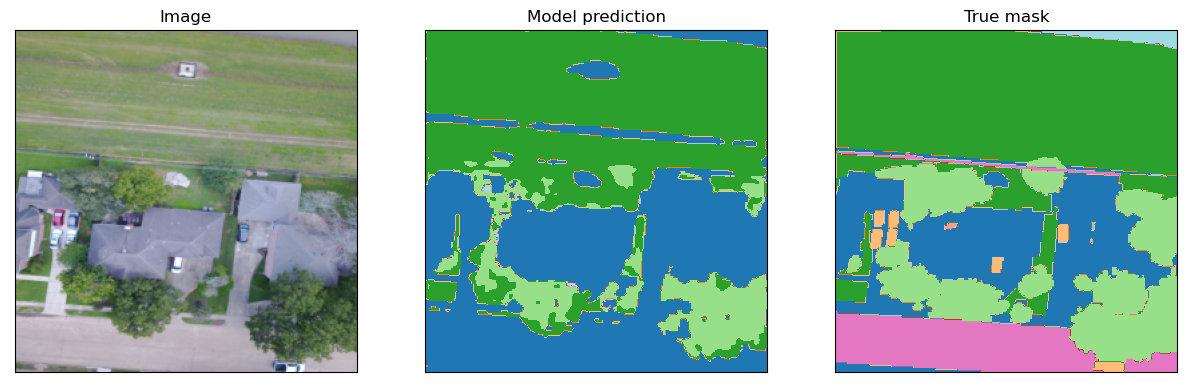

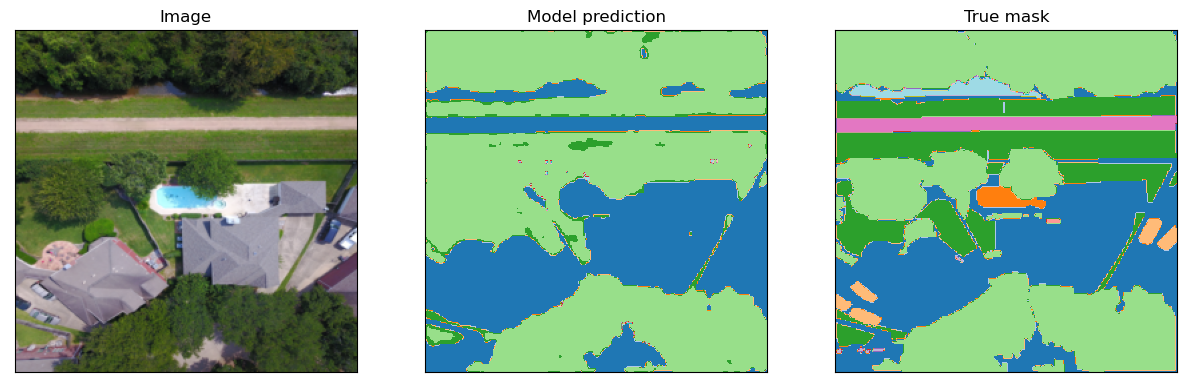

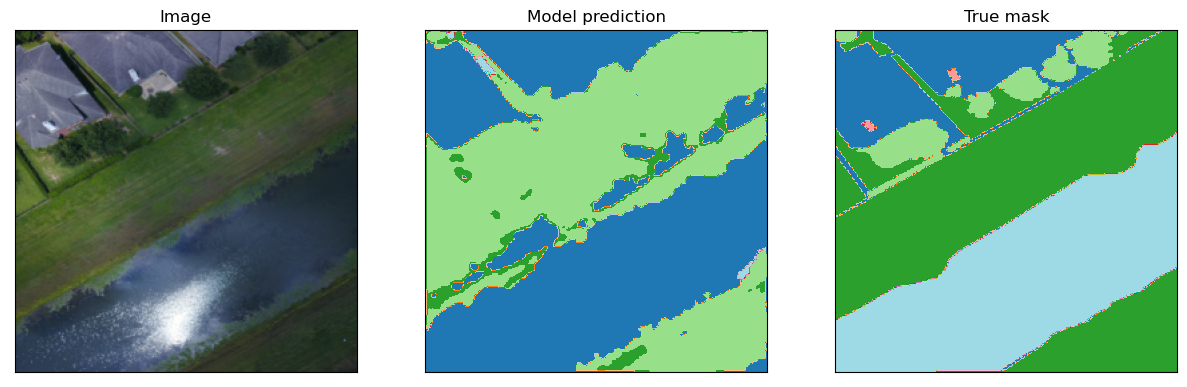

In [64]:
visualise_model_performance(model, 10)
visualise_model_performance(model, 100)
visualise_model_performance(model, 200)

The model is starting the get the hang of things but clearly there is still a lot of room for improvement.

# 5. Submission

In [88]:
os.getcwd()
os.mkdir('test_predictions')

In [89]:
# Load and transform test images
test_img_link_list = sorted(glob.glob(config.TEST_IMG_PATH + '/*'))
torch_list = [val_dataset.transform_img(Image.open(link)) for link in test_img_link_list]

In [103]:
model.eval()

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm(range(len(torch_list))):
    img_id = test_img_link_list[i].split('\\')[-1].split('.')[0]
    img = torch_list[i].unsqueeze(0)
    output = model(img)
    output = torch.argmax(output, dim=1).squeeze(0)
    output = np.uint8(output)
    output = Image.fromarray(output)
    #output.save(f"/kaggle/working/test_predictions/{img_id}.png")
   # path1 = "/msc-ai-2022/test_predictions/{img_id}.png"
   # output_path = "C:/Users/ASUS/Desktop/下载/msc-ai-2022/test_predictions/{img_id}.png"
    output.save(f"C:/Users/ASUS/Desktop/下载/msc-ai-2022/test_predictions/{img_id}.png")

100%|██████████| 112/112 [00:31<00:00,  3.55it/s]


In [104]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'C:/Users/ASUS/Desktop/下载/msc-ai-2022/test_predictions/'  # CHANGE DIRECTORY IF NEEDED
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))
                
            print(i)
            if i[0] != '.':
                mask = Image.open(dir + i)
                mask = mask.resize((1024, 1024), resample=Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

10170.png
10171.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25132\2858926011.py:40: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = mask.resize((1024, 1024), resample=Image.NEAREST)


10184.png
10566.png
10808.png
10812.png
6413.png
6424.png
6427.png
6450.png
6455.png
6457.png
6459.png
6462.png
6463.png
6465.png
6466.png
6476.png
6481.png
6492.png
6499.png
6504.png
6546.png
6550.png
6560.png
6569.png
6574.png
6608.png
6644.png
6648.png
6654.png
6656.png
6657.png
6662.png
6677.png
6701.png
6710.png
6717.png
6795.png
6804.png
6854.png
6856.png
6901.png
6908.png
6933.png
6963.png
6974.png
6982.png
6994.png
6996.png
7009.png
7193.png
7235.png
7236.png
7241.png
7251.png
7257.png
7263.png
7265.png
7270.png
7272.png
7300.png
7304.png
7308.png
7311.png
7323.png
7330.png
7356.png
7366.png
7412.png
7415.png
7422.png
7427.png
7429.png
7438.png
7457.png
7466.png
7481.png
7485.png
7489.png
7521.png
7541.png
7556.png
7560.png
7580.png
7582.png
7586.png
7593.png
7597.png
7673.png
7719.png
7721.png
7829.png
8361.png
8516.png
8526.png
8774.png
8786.png
8833.png
8906.png
8947.png
8962.png
9006.png
9070.png
9079.png
9084.png
9087.png
9101.png
9106.png
9110.png
9723.png
9795.png


# How to improve

The above solution is a very simple pipeline and gives a leaderboard score similar to the basline. From here, you can improve in various ways. This is a good practice in general: start with a simple baseline solution and try to improve from there. Below we outline a couple ideas you can try out but keep in mind that this is not an exhaustive list! It's often the unique ideas that give you an edge in Kaggle challenges.

### 1. Improving the speed of iteration
One of the best practices both in industry and on Kaggle is to create a pipeline in which you can iterate ideas quickly. It should take you no more than 20min (for this dataset) to train and evaluate a model. It doesn't mean that your final soultion should be trained in 20mins but it means that if you want to change some model parameters/data variants/training properties, you should be able to assess if your new idea is worth more of your efforts in about that much time. How you could speed up the above timeline:
- Include preprocessing step. Instead of loading large (4000x3000) images in the dataloader, resize them beforehand
- Increase number of workers in the dataloader
- Set up a better evaluation metric than accuracy. Ideally, it should be in line with the evaluation metric of the competition. This will allow your validation set to give a good approximation of your performance on the leaderboard
- Use GPUs for training. This can drive down your training time from hours to just minutes. Easy two options are: Google Colab (10 euro a month), or Kaggle (free but limit of 33 GPU hours per week - should be enough honestly)

### 2. Improving performance
Once you are able to iterate quickly here are a few ideas on how you could improve performance:
- Perform Exploratory Data Analysis (EDA). Think of the key problems with the dataset and how you could tackle them.
- Include transformations for you training set. You can use [native PyTorch transformations](https://pytorch.org/vision/stable/transforms.html) or I can recommend the [Albumentations library](https://albumentations.ai/) specifically designed for image transformations. Nice tutorial [here](https://www.youtube.com/watch?v=rAdLwKJBvPM)
- Try different architectures - Unet is a good start
- Improve your understanding of the training process. You could plot loss/accuracy/other metrics over time to get an idea of how many epochs you need to reach convergence. You could even use an experiment tracking software such as [Weights & Biases](https://wandb.ai/site)
- Experiment with different learning rates. You could even use a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- Experiment with different loss functions
- Experiment with different image sizes
- Use transfer learning. This means you would need to obtain a semantic segmentation model from somewhere (no links here :) ) and replace the last layer to output 25 channels (because we have 25 classes in our dataset). Keep in mind that models pretrained on seemingly unrelated datasets like Imagenet can still work here! This is because the lower-level layers learn simple features such as lines, shapes, and colours, which can be useful for our problem as well.
- Think of a better train/validation split

<br>

This is already a lot of things to implement. Given that you have limited time, try to implement a few and maybe some of your own ideas and your leaderboard score surely will improve. Good luck!
